In [1]:
import numpy as np
from numba import jit
from numba.experimental import jitclass
from abc import ABC, abstractmethod
from typing import List, Union, Dict
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# this can be compiled
@jit(nopython=True)
def hmm_forward(prob, A, P):
    '''
    Forward algorithm for the HMM
    prob: numpy (n,n_states) array with
        the probability of each observation
        for each state
    A: numpy (n_states,n_states) array with the state
        transition matrix
    P: numpy (n_states,) array with the initial
        state probability
    returns:
        alpha: numpy (n,n_states) array meaning
            p(state=i|obs <= i)
        c: numpy (n,) array with the normalization
            constants
    '''
    n_obs = prob.shape[0]
    n_states = prob.shape[1]
    alpha = np.zeros((n_obs,n_states), dtype = np.float64)
    c = np.zeros(n_obs, dtype = np.float64)
    alpha[0] = P*prob[0]
    c[0] = 1 / np.sum(alpha[0])
    alpha[0] *= c[0]
    for i in range(1, n_obs):
        alpha[i] = np.dot(A.T, alpha[i-1]) * prob[i] 
        c[i] = 1 / np.sum(alpha[i])
        alpha[i] *= c[i]
    return alpha, c

# this can be compiled
@jit(nopython=True)
def hmm_backward_sample(A, alpha, z, transition_counter, init_state_counter):
    '''
    Backward sample from the state transition matrix and state sequence
    A: numpy (n_states,n_states) array with the state
        transition matrix
    alpha: numpy (n,n_states) array meaning
        p(state=i|obs <= i)		
    z: numpy (n,) to store the sample of state sequence
    transition_counter: numpy (n_states,n_states) array to store 
        transition counts to be used to sample a state transition 
        matrix
    init_state_counter: numpy (n_states,) array to store the
        number of times state i is the initial one
    returns:
        none (q and transition_counter are changed inside this function)
    '''	
    # backward walk to sample from the state sequence
    n = z.size
    # sample the last hidden state with probability alpha[-1]
    z[n-1] = np.searchsorted(np.cumsum(alpha[-1]), np.random.random(), side = "right")
    # aux variable
    p = np.zeros(A.shape[0], dtype = np.float64)
    # iterate backwards
    for j in range(n-2, -1, -1):
        # from formula
        p = A[:,z[j+1]] * alpha[j] 
        # normalize (from formula)
        p /= np.sum(p) 
        # sample hidden state with probability p
        z[j] = np.searchsorted(np.cumsum(p), np.random.random(), side="right")
        # increment transition counter (we can do this calculation incrementally)
        transition_counter[z[j],z[j+1]] += 1 
    # increment initial state counter
    init_state_counter[z[0]] += 1

In [3]:
# univariate gaussian
class uDefinedGaussianEmission():
    def __init__(self, side:int = 1):
        self.side = side
        # variables to be computed
        self.var = None
        self.mean = None        
           
    def view(self, plot_hist = False):
        print('** Univariate Gaussian Emission **')
        print('Mean')
        print(self.mean)
        print('Variance')
        print(self.var)
        print()

    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
            
        e = 10
        ye = np.lib.stride_tricks.sliding_window_view(y, e)
        ye = ye[np.arange(0, ye.shape[0], e)]
        
        yem = np.mean(ye, axis = 1)
        yev = np.var(ye, axis = 1)
        
        if self.side > 0:
            idx = yem > 0
        elif self.side < 0:
            idx = yem < 0
        
        self.mean = np.mean(yem[idx])
        self.var = np.mean(yev[idx])
        self.w_norm = np.abs(self.mean / self.var)
            
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        return np.exp(-0.5 * np.power(y - self.mean, 2) / self.var) / np.sqrt(2*np.pi*self.var)
    
    def posterior_predictive(self, **kwargs):
        return self.mean, self.var
    
    def predict_pi(self, **kwargs):
        return 1
    
# run bayesian inference
y = np.random.normal(0, np.sqrt(0.5), 1000)
g = uDefinedGaussianEmission()
g.estimate(y)
g.view(True)

** Univariate Gaussian Emission **
Mean
0.20287666355870676
Variance
0.45660240478233793



In [4]:
# univariate HMM

class uDefinedHMM(object):
    def __init__(
                self,
                p = 0.95,
                pred_l = None,
                **kwargs
                ):
        '''
        emissions: list of instances derived from Emission
                one for each state
        n_gibbs: number of gibbs samples
        A_zeros: list of lists with entries of A to be set to zero
        emissions_indexes: list of lists
            example
                    emissions_indexes = [[0,2],[1,3]]
                means 
                    emission[0] is applied to states 0 and 2
                    emission[1] is applied to states 1 and 3
                also, this implies that the number of states is 4!
        f_burn: fraction to burn  
        '''
        self.pred_l = None
        self.P = np.array([0.5, 0.5])
        self.emissions = [uDefinedGaussianEmission(1), uDefinedGaussianEmission(-1)]
        self.A = np.array([[p, 1-p],[1-p,p]])
        self.w_norm = 1

    def view(self, plot_hist = False):
        '''
        plot_hist: if true, plot histograms, otherwise just show the parameters
        '''
        print('** Defined HMM **')
        print('Initial state probability')
        print(self.P)
        print('State transition matrix')
        print(np.round(self.A,3))
        for s, emission in enumerate(self.emissions):
            print(f'Defined HMM Emission {s}')
            emission.view(plot_hist = plot_hist)

    def estimate(self, y:np.ndarray, **kwargs):	 
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        for e in self.emissions:
            e.estimate(y)
        # normalization constant
        self.w_norm = 0
        for s in range(2):
            self.w_norm = max(self.w_norm, self.emissions[s].w_norm)
        if self.w_norm == 0: self.w_norm = 1

    def next_state_prob(self, y:np.ndarray, x:np.ndarray = None, l:int = None):
        '''
        computes a vector with the next state probability
        given a input sequence
        xyq: numpy (n,self.p) array with observation
        l: integer to filter recent data in y -> y=y[-l:]
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        if x is not None:             
            assert x.ndim == 2,"x must be a matrix"
            assert y.size == x.shape[0], "x and y must have the same number of observations"
        # just return the initial state probability 
        if y.size == 0:
            return self.P
        if l is not None:
            y = y[-l:]
            if x is not None: x = x[-l:]
        n = y.size
        prob = np.zeros((n, 2), dtype = np.float64) 
        # evaluate the probability of each observation
        prob[:,0] = self.emissions[0].prob(y = y)
        prob[:,1] = self.emissions[1].prob(y = y)
        alpha, _ = hmm_forward(prob, self.A, self.P)
        next_state_prob = np.dot(self.A.T, alpha[-1])  
        return next_state_prob	

    def get_weight(
                self, 
                y:np.ndarray, 
                x:np.ndarray = None, 
                xq:np.ndarray = None, 
                normalize = True, 
                **kwargs
                ):
        '''
        compute betting weight given an input sequence
        y: numpy (n,p) array with a sequence
            each point is a joint observations of the variables
        l: integer to filter recent data in y -> y=y[-l:]
        returns:
            w: numpy (p,) array with weights to allocate to each asset
            in y
        '''

        # next state probability for all states
        next_state_prob = self.next_state_prob(y, x, self.pred_l)
        # build the mixture
        mixture_mean = 0
        mixture_var = 0
        for s in range(2):
            mean, var = self.emissions[s].posterior_predictive(xq = xq)
            mixture_mean += next_state_prob[s]*mean
            mixture_var += next_state_prob[s]*(var + mean*mean)
        mixture_var -= mixture_mean*mixture_mean
        w = mixture_mean / mixture_var
        if normalize:
            w /= self.w_norm
        return np.atleast_1d(w)

dict_keys(['XP', 'EO', 'CF', 'GX', 'Z ', 'ST', 'IB', 'ES', 'NQ', 'PT', 'TP'])


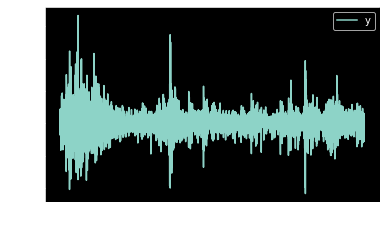

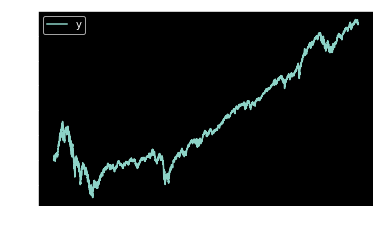

In [5]:
# test on STM with real data
import stm
import pickle
import pandas as pd
data = {}
filepath = 'indexes_data.pkl'
#filepath = 'fi_data.pkl'
#filepath = 'comm_data.pkl'

# load from pickle
with open(filepath, 'rb') as inp:
    tmp = pickle.load(inp)
    data.update(tmp) 
print(data.keys())
data = data['NQ']
data.columns = data.columns.droplevel(1)
data = data[[data.columns[0]]].dropna().pct_change().dropna()
data.columns = ['y']
data.index = pd.to_datetime(data.index)
data.plot()
plt.show()
np.cumsum(data, axis = 0).plot()
plt.show()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

** Defined HMM **
Initial state probability
[0.5 0.5]
State transition matrix
[[0.97 0.03]
 [0.03 0.97]]
Defined HMM Emission 0
** Univariate Gaussian Emission **
Mean
0.003282005371053297
Variance
0.0002220929750381989

Defined HMM Emission 1
** Univariate Gaussian Emission **
Mean
-0.0038349318613442405
Variance
0.0003250204313760742



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.85s/it]


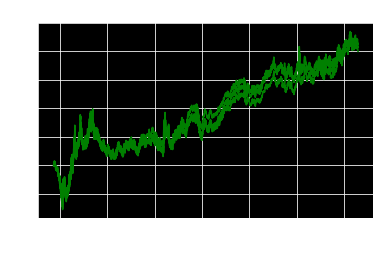

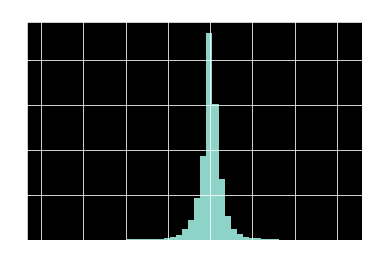

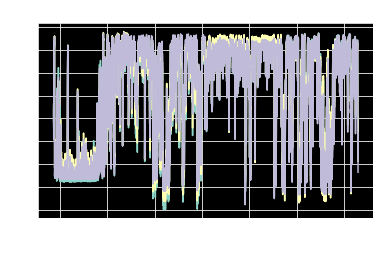

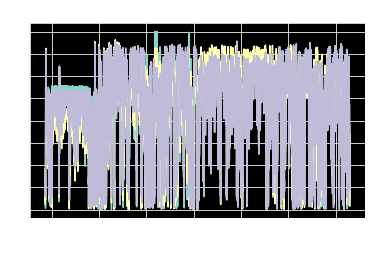

** REJECT STRATEGY **


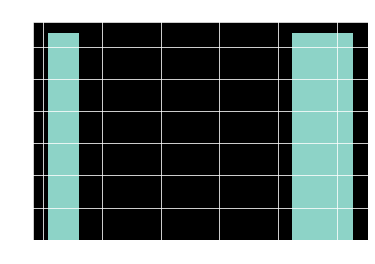

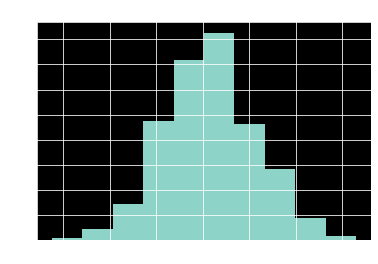


** PERFORMANCE SUMMARY **

Return:  0.03154180776817526
Standard deviation:  0.13103600633458504
Sharpe:  0.2407109973089149



In [6]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

uhmm = uDefinedHMM(p = 0.97)
uhmm.estimate(y = data.values.ravel())
uhmm.view()

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
     )

paths.post_process()